In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.set_cmap('gray')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device:", device)

using device: cuda


<Figure size 640x480 with 0 Axes>

In [132]:
tf_train = transforms.Compose([
    #transforms.RandomResizedCrop((224, 224), (0.7, 1)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=tf_train)

batch_size = 64
train_ldr = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
print("training data: {} images, {} batches".format(len(train), len(train_ldr)))


training data: 60000 images, 938 batches


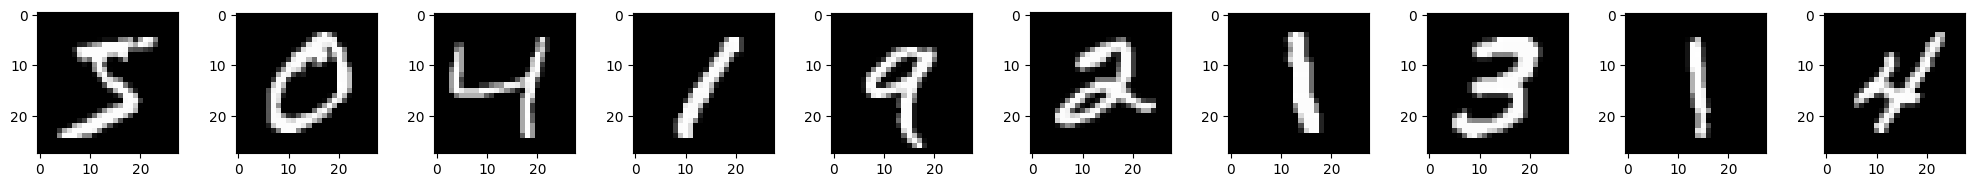

In [6]:
fig, axs = plt.subplots(1, 10, figsize=(20, 4))
fig.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ax.imshow(train.data[i].squeeze())


In [134]:
def add_noise(x:torch.Tensor, scale: float) -> torch.Tensor:
    noise = torch.randn(*x.shape).to(x.device)
    noised = x + noise * (scale/0.5) - (scale*0.5/0.5)
    return noised


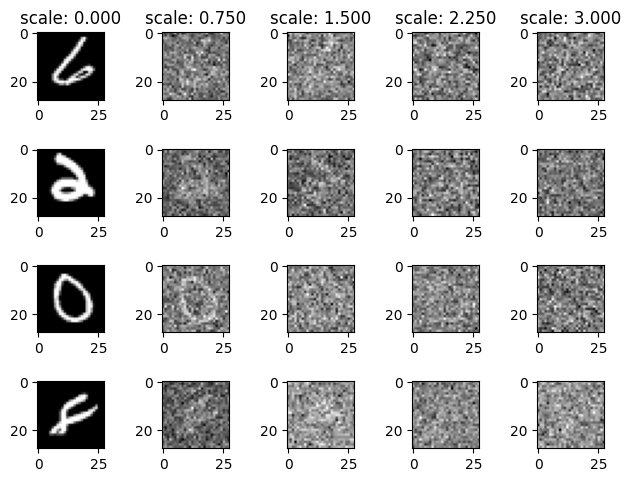

In [135]:
b = next(enumerate(train_ldr))[1][0]
f4b = b[:4]

steps = 5
levels = np.linspace(0, 3, steps)

fig, axs = plt.subplots(4, steps)
fig.set_facecolor('white')
fig.tight_layout()
for i, level in enumerate(levels):
    noised_f4b = add_noise(f4b, level)
    axs[0][i].set_title(f'scale: {level:0.3f}')
    for j in range(4):
        axs[j][i].imshow(noised_f4b[j].squeeze())

In [120]:
from unet import UNet

model = UNet(1, 1)
model.to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

steps = 20
levels = np.linspace(0, 3, steps)
epochs = 1

losses = []
for epoch in range(epochs):
    print("epoch: {}; lr: {:.6f}".format(epoch, scheduler.get_last_lr()[0]))
    model.train()
    train_loss = 0
    for batch_idx, (batch, _) in (pbar := tqdm(enumerate(train_ldr), total=len(train_ldr))):
        for noise_level in range(steps-1):
            batch = batch.to(device)
            noised_target = add_noise(batch, levels[noise_level])
            noised = add_noise(batch, levels[noise_level+1])
            y = model(noised)
            loss = loss_fn(y, noised_target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
        pbar.set_description("    loss: {:.3f}".format(
            train_loss / (batch_idx + 1) / steps))
    losses.append(train_loss / len(train_ldr) / steps)
    scheduler.step()


epoch: 0; lr: 0.050000


    loss: 3.548: 100%|██████████| 938/938 [14:03<00:00,  1.11it/s]


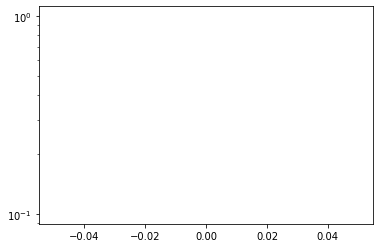

In [888]:
ax = plt.subplot()
ax.plot(np.arange(len(losses)), losses)
ax.set_yscale('log')
plt.show()

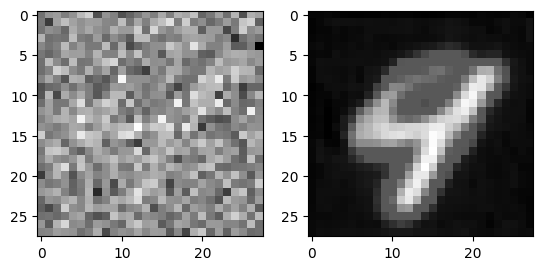

In [125]:
x = next(enumerate(train_ldr))[1][0][0].unsqueeze(0)
x = x.to(device)
x = add_noise(x, 0.8)

fig, axs = plt.subplots(1, 2)
fig.set_facecolor('white')
axs[0].imshow(x.squeeze().cpu())

with torch.no_grad():
    model.eval()
    out = model(x)
    axs[1].imshow(out.squeeze().cpu())

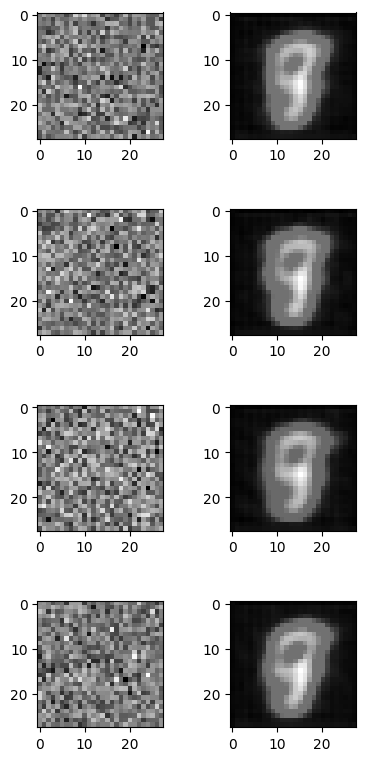

In [131]:
x = torch.normal(0, 1, (4, 1, 28, 28))
x = x.to(device)
#x = add_noise(x, 0.4)

fig, axs = plt.subplots(4, 2, figsize=(4, 8))
fig.set_facecolor('white')
fig.tight_layout()

with torch.no_grad():
    out = model(x)
    for i, v in enumerate(x):
        axs[i][0].imshow(v.squeeze().cpu())
        axs[i][1].imshow(out[i].squeeze().cpu())